In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=100
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [117]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
print(train.shape)
print(test.shape)
print(sample.shape)

(903653, 12)
(804684, 12)
(617242, 2)


# Let's look at the features and response variable to understand the data

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
channelGrouping         903653 non-null object
date                    903653 non-null int64
device                  903653 non-null object
fullVisitorId           903653 non-null object
geoNetwork              903653 non-null object
sessionId               903653 non-null object
socialEngagementType    903653 non-null object
totals                  903653 non-null object
trafficSource           903653 non-null object
visitId                 903653 non-null int64
visitNumber             903653 non-null int64
visitStartTime          903653 non-null int64
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


In [5]:
train.describe()

,date,visitId,visitNumber,visitStartTime
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09


In [6]:
train.channelGrouping.unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates',
       'Direct', 'Display', 'Social', '(Other)'], dtype=object)

In [8]:
len(train.fullVisitorId.unique())

742735

In [10]:
type(train.date[0]) # convert datetime

numpy.int64

In [11]:
train.device[0] # browser(dene), isMobile

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

In [20]:
train.geoNetwork[0] # continent, country, subcontinent

'{"continent": "Asia", "subContinent": "Western Asia", "country": "Turkey", "region": "Izmir", "metro": "(not set)", "city": "Izmir", "cityId": "not available in demo dataset", "networkDomain": "ttnet.com.tr", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [ ]:
train.sessionId  # get rid of

In [15]:
train.socialEngagementType.unique() # get rid of

array(['Not Socially Engaged'], dtype=object)

In [16]:
train[train.socialEngagementType=="Socially Engaged"]

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime


In [23]:
train.totals[100]

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1"}'

In [22]:
len(train.totals.unique())

14840

In [26]:
train.trafficSource[1000]

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "(not provided)", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}, "isTrueDirect": true}'

In [27]:
train.visitNumber.unique()

array([  1,   2,   3,   5,  11,   4,  57,   6,  56,   7,  20,   8,  15,
         9,  25,  24,  14,  89, 136,  13,  85,  10, 105,  22,  21,  48,
        18,  26,  17,  83,  38,  84,  27,  42, 100,  31,  16,  30,  59,
        50,  19,  51,  29, 160,  52,  12,  63,  23,  47,  49,  28,  34,
       178,  88,  33, 317,  93, 140,  35,  41,  91,  92,  74, 309,  43,
        61,  46,  45,  32, 108,  86, 195,  36, 236,  72, 162, 235,  90,
        76,  77,  94,  96,  73,  78,  97,  87, 304, 106, 107, 389,  68,
        98, 132,  58, 266, 267, 221,  39, 121, 143, 142, 174, 175, 189,
       191,  55, 190, 104, 245, 204,  37,  82, 137, 206, 101,  62, 110,
       156, 158, 157, 159, 138, 109, 194, 193, 147, 254,  71,  53, 144,
       145, 146,  80, 253,  99, 134, 135, 102,  44, 130,  95,  75, 103,
       315,  70,  69, 117, 163, 154, 153, 283,  65, 262, 263, 295, 297,
       298, 219,  64, 296, 155, 141, 169, 170,  60, 207,  54, 187, 133,
       118, 264,  67,  66, 126,  40, 122, 325, 326, 197, 167, 19

# Data Cleaning

# Handle Json formatted columns 

# Let's understand the logic of json_normalize

In [5]:
import numpy as np 
import pandas as pd 
ifile = "train.csv"
num_rows = 3
df = pd.read_csv(ifile, nrows = num_rows, converters={'fullVisitorId': str})
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386


In [7]:
type(df.device[0])

str

In [118]:
import json
from pandas.io.json import json_normalize

In [9]:
j = json.loads(df["totals"][0])
j
type(j)

dict

In [10]:
j

{'visits': '1',
 'hits': '1',
 'pageviews': '1',
 'bounces': '1',
 'newVisits': '1'}

In [11]:

json_normalize(j)

,bounces,hits,newVisits,pageviews,visits
0,1,1,1,1,1


In [6]:
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource'] # List columns where data is stored in JSON format

# Apply converter to convert JSON format data into JSON object
json_conv = {col: json.loads for col in (json_cols)}

# Read the CSV with the new converter
df = pd.read_csv("train.csv", 
    dtype={'fullVisitorId': str},
    converters=json_conv, 
    nrows=num_rows)

df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",1131660440785968503,"{'continent': 'Asia', 'subContinent': 'Western...",1131660440785968503_1472830385,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472830385,1,1472830385
1,Organic Search,20160902,"{'browser': 'Firefox', 'browserVersion': 'not ...",377306020877927890,"{'continent': 'Oceania', 'subContinent': 'Aust...",377306020877927890_1472880147,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472880147,1,1472880147
2,Organic Search,20160902,"{'browser': 'Chrome', 'browserVersion': 'not a...",3895546263509774583,"{'continent': 'Europe', 'subContinent': 'South...",3895546263509774583_1472865386,Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1472865386,1,1472865386


In [20]:
tdf = json_normalize(list(df["totals"])) # json_normalize accept dict or list of dict
tdf.head()

,bounces,hits,newVisits,pageviews,visits
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1


In [2]:
# Handle the four json columns at the same time
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(list(df[column]))
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

#print(os.listdir("../input"))

In [3]:
%%time
df_train = load_df()
df_test = load_df("test.csv")

KeyboardInterrupt: 

## Reduce+Data+Size¶
## We can take the below steps: 
1) Reduce the long default values to simple strings

2) Download 64 bit numbers to 32 bit where possible

3) Create categorical variables from strings
The below code addresses 1st step

In [24]:
def replace_def_vals(df):
    df.replace({'(not set)': np.nan,
               'not available in demo dataset': np.nan,
               '(not provided)': np.nan,
               'unknown.unknown': np.nan,
               '(none)':np.nan,
               '/':np.nan,
               'Not Socially Engaged':np.nan},
              inplace=True)

In [25]:
%%time
replace_def_vals(df_train)
replace_def_vals(df_test)

CPU times: user 1min 38s, sys: 5.6 s, total: 1min 44s
Wall time: 1min 46s


In [ ]:
f = './train_flat.csv'
df_train.to_csv(f, index = False)
s = os.stat(f)
num_lines = sum(1 for line in open(f))
print(x + ":" + str(round(s.st_size / (1024 * 1024)) ) + " MB : " + str(num_lines) + " lines")

In [ ]:
f = './test_flat.csv'
df_test.to_csv(f, index = False)
s = os.stat(f)
num_lines = sum(1 for line in open(f))
print(x + ":" + str(round(s.st_size / (1024 * 1024)) ) + " MB : " + str(num_lines) + " lines")

In [4]:
df_train.to_csv('df_train1.csv')
df_test.to_csv('df_test1.csv')

NameError: name 'df_train' is not defined

In [6]:
df_train=pd.read_csv('df_train1.csv')
df_test=pd.read_csv('df_test1.csv')

/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3,50) have mixed types. Specify dtype option on import or set low_memory=False.

/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [29]:
# code chunk that I saw in Gabriel Preda kernel
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    
    print("\n Total of Sales % of Total: ", round((df_train[df_train['totals_transactionRevenue'] != np.nan]['totals_transactionRevenue'].count() / len(df_train['totals_transactionRevenue']) * 100),4))
    
    return 

In [7]:
df_train.device_browserVersion.unique()

array([nan])

In [30]:
# calling the missing values function
missing_values(df_train) 

Total columns at least one Values: 
                                                    Total     Percent
device_browserVersion                              903653  100.000000
socialEngagementType                               903653  100.000000
geoNetwork_cityId                                  903653  100.000000
device_operatingSystemVersion                      903653  100.000000
geoNetwork_latitude                                903653  100.000000
geoNetwork_longitude                               903653  100.000000
device_mobileInputSelector                         903653  100.000000
geoNetwork_networkLocation                         903653  100.000000
device_flashVersion                                903653  100.000000
device_mobileDeviceModel                           903653  100.000000
device_mobileDeviceMarketingName                   903653  100.000000
device_browserSize                                 903653  100.000000
device_mobileDeviceInfo                            903

In [8]:
print("Variables not in test but in train : ", set(df_train.columns).difference(set(df_test.columns)))

Variables not in test but in train :  {'trafficSource_campaignCode', 'totals_transactionRevenue'}


In [9]:
train_df=df_train
test_df=df_test

Let's get rid of constant columns

In [33]:
train_df.device_browserVersion.unique()

array([nan])

In [11]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device_browserSize',
 'device_browserVersion',
 'device_flashVersion',
 'device_language',
 'device_mobileDeviceBranding',
 'device_mobileDeviceInfo',
 'device_mobileDeviceMarketingName',
 'device_mobileDeviceModel',
 'device_mobileInputSelector',
 'device_operatingSystemVersion',
 'device_screenColors',
 'device_screenResolution',
 'geoNetwork_cityId',
 'geoNetwork_latitude',
 'geoNetwork_longitude',
 'geoNetwork_networkLocation',
 'totals_visits',
 'trafficSource_adwordsClickInfo.criteriaParameters']

In [12]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["trafficSource_campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [13]:
train_df.head(3)

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,NaN,ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organic,NaN,google
1,1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,NaN,Oceania,Australia,NaN,dodo.net.au,NaN,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organic,NaN,google
2,2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,NaN,NaN,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organic,NaN,google


In [14]:
train_df.isnull().sum()

Unnamed: 0                                           0
channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device_browser                                       8
device_deviceCategory                                0
device_isMobile                                      0
device_operatingSystem                            4695
geoNetwork_city                                 542491
geoNetwork_continent                              1468
geoNetwork_country                                1468
geoNetwork_metro                                709995
geoNetwork_networkDomain                        390915
geoNetwork_region                               536056
geoNetwork_subContinent                           1468
totals_bou

In [15]:
from sklearn.preprocessing import LabelEncoder
import datetime
train_df["totals_transactionRevenue"] = train_df["totals_transactionRevenue"].astype('float')
# Impute 0 for missing target values
train_df["totals_transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals_transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device_browser", "device_isMobile",
            "device_deviceCategory", "device_operatingSystem", 
            "geoNetwork_city", "geoNetwork_continent", 
            "geoNetwork_country", "geoNetwork_metro",
            "geoNetwork_networkDomain", "geoNetwork_region", 
            "geoNetwork_subContinent", "trafficSource_adContent", 
            "trafficSource_adwordsClickInfo.adNetworkType", 
            "trafficSource_adwordsClickInfo.gclId", 
            "trafficSource_adwordsClickInfo.page", 
            "trafficSource_adwordsClickInfo.slot", "trafficSource_campaign",
            "trafficSource_keyword", "trafficSource_medium", 
            "trafficSource_referralPath", "trafficSource_source",
            'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))


num_cols = ["totals_hits", "totals_pageviews", "visitNumber", "visitStartTime", 'totals_bounces',  'totals_newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)



channelGrouping
device_browser
device_isMobile
device_deviceCategory
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
trafficSource_adContent
trafficSource_adwordsClickInfo.adNetworkType
trafficSource_adwordsClickInfo.gclId
trafficSource_adwordsClickInfo.page
trafficSource_adwordsClickInfo.slot
trafficSource_campaign
trafficSource_keyword
trafficSource_medium
trafficSource_referralPath
trafficSource_source
trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect


In [17]:
test_df.head(2)

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,0,4,20171016,6167871330617112363,1508151024,2.0,1.508151e+09,34,0,0,6,954,2,175,121,24690,481,15,NaN,4.0,NaN,4.0,62,3,59008,1,11,3,33,0,3326,4,3195,207
1,1,4,20171016,0643697640977915618,1508175522,1.0,1.508176e+09,34,0,0,19,947,3,184,121,30734,22,18,NaN,5.0,1.0,5.0,62,3,59008,1,11,3,33,1,3326,4,3195,207


In [18]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test_df['year'] = test_df['date'].apply(lambda x: x.year)
test_df['month'] = test_df['date'].apply(lambda x: x.month)
test_df['day'] = test_df['date'].apply(lambda x: x.day)
test_df.head(2)

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,year,month,day
0,0,4,2017-10-16,6167871330617112363,1508151024,2.0,1.508151e+09,34,0,0,6,954,2,175,121,24690,481,15,NaN,4.0,NaN,4.0,62,3,59008,1,11,3,33,0,3326,4,3195,207,2017,10,16
1,1,4,2017-10-16,0643697640977915618,1508175522,1.0,1.508176e+09,34,0,0,19,947,3,184,121,30734,22,18,NaN,5.0,1.0,5.0,62,3,59008,1,11,3,33,1,3326,4,3195,207,2017,10,16


In [19]:
#train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
train_df['year'] = train_df['date'].apply(lambda x: x.year)
train_df['month'] = train_df['date'].apply(lambda x: x.month)
train_df['day'] = train_df['date'].apply(lambda x: x.day)
train_df.head(2)

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,year,month,day
0,0,4,2016-09-02,1131660440785968503,1472830385,1.0,1.472830e+09,34,0,0,19,377,2,209,121,37454,192,20,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,33,1,3326,4,3195,207,2016,9,2
1,1,4,2016-09-02,377306020877927890,1472880147,1.0,1.472880e+09,42,0,0,6,954,4,11,121,10097,481,0,1.0,1.0,1.0,1.0,0.0,62,3,59008,1,11,3,33,1,3326,4,3195,207,2016,9,2


In [20]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  {'totals_transactionRevenue'}


In [34]:
test_df.isnull().sum()

Unnamed: 0                                           0
channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device_browser                                       0
device_deviceCategory                                0
device_isMobile                                      0
device_operatingSystem                               0
geoNetwork_city                                      0
geoNetwork_continent                                 0
geoNetwork_country                                   0
geoNetwork_metro                                     0
geoNetwork_networkDomain                             0
geoNetwork_region                                    0
geoNetwork_subContinent                              0
totals_bou

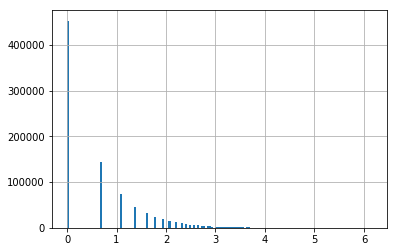

In [32]:
np.log(train_df.totals_pageviews).hist(bins=150)

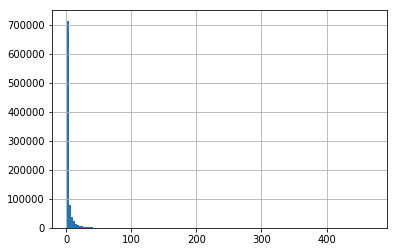

In [33]:
train_df.totals_pageviews.hist(bins=150)

In [30]:
print(train_df.totals_pageviews.mean())
print(train_df.totals_pageviews.median())

3.8497642086297095
1.0


In [25]:
train_df.totals_pageviews.unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  20.,  19.,  21.,  25.,
        22.,  26.,  23.,  24.,  30.,  27.,  29.,  28.,  32.,  31.,  34.,
        33.,  38.,  35.,  40.,  36.,  37.,  39.,  43.,  45.,  47.,  52.,
        44.,  50.,  46.,  49.,  51.,  56.,  59.,  71.,  57.,  82.,  84.,
        92.,  90.,  41.,  79., 138.,  48.,  69., 112.,  42.,  65.,  60.,
        63.,  68.,  58.,  74., 165.,  53.,  54.,  55.,  61.,  70.,  80.,
        78.,  72., 188.,  73.,  62.,  75.,  86., 197., 148.,  67., 102.,
        64., 103., 144.,  nan,  81., 119., 104., 128.,  87., 111.,  66.,
        83., 135.,  94.,  91.,  99.,  77., 118., 202., 127.,  93., 106.,
       155., 117.,  76.,  89.,  85., 143., 105., 115.,  95., 110., 137.,
       120., 116., 208., 126., 400., 101., 108., 333.,  97.,  96.,  98.,
       125., 113., 327., 154., 121., 183., 123., 141., 224.,  88., 195.,
       343., 156., 193., 100., 150., 122., 145., 17

In [35]:
train_df.drop(['totals_bounces','totals_newVisits'],axis=1, inplace=True)
test_df.drop(['totals_bounces','totals_newVisits'],axis=1, inplace=True)
test_df.totals_pageviews.fillna(round(test_df.totals_pageviews.median()), inplace=True)
train_df.dropna(inplace=True)

In [36]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  {'totals_transactionRevenue'}


In [37]:
train_df.head(3)

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_hits,totals_pageviews,totals_transactionRevenue,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,year,month,day
0,0,4,2016-09-02,1131660440785968503,1472830385,1.0,1.472830e+09,34,0,0,19,377,2,209,121,37454,192,20,1.0,1.0,0.0,62,3,59008,1,11,3,33,1,3326,4,3195,207,2016,9,2
1,1,4,2016-09-02,377306020877927890,1472880147,1.0,1.472880e+09,42,0,0,6,954,4,11,121,10097,481,0,1.0,1.0,0.0,62,3,59008,1,11,3,33,1,3326,4,3195,207,2016,9,2
2,2,4,2016-09-02,3895546263509774583,1472865386,1.0,1.472865e+09,34,0,0,19,474,3,184,121,24802,98,18,1.0,1.0,0.0,62,3,59008,1,11,3,33,1,3326,4,3195,207,2016,9,2


In [38]:
test_df.head(3)

,Unnamed: 0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_hits,totals_pageviews,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,year,month,day
0,0,4,2017-10-16,6167871330617112363,1508151024,2.0,1.508151e+09,34,0,0,6,954,2,175,121,24690,481,15,4.0,4.0,62,3,59008,1,11,3,33,0,3326,4,3195,207,2017,10,16
1,1,4,2017-10-16,0643697640977915618,1508175522,1.0,1.508176e+09,34,0,0,19,947,3,184,121,30734,22,18,5.0,5.0,62,3,59008,1,11,3,33,1,3326,4,3195,207,2017,10,16
2,2,4,2017-10-16,6059383810968229466,1508143220,1.0,1.508143e+09,34,0,0,6,954,3,68,121,32535,481,21,7.0,7.0,62,3,59008,1,11,3,33,1,3326,4,3195,207,2017,10,16


In [39]:
num_cols = ["totals_hits", "totals_pageviews", "visitNumber", "visitStartTime"]    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

In [40]:
df_train.to_csv('df_train2.csv')
df_test.to_csv('df_test2.csv')

In [56]:
# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
val_df = train_df[train_df['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals_transactionRevenue"].values)
val_y = np.log1p(val_df["totals_transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols + ["year" , "month" , "day"]] 
val_X = val_df[cat_cols + num_cols + ["year" , "month" , "day"]] 
test_X = test_df[cat_cols + num_cols + ["year" , "month" , "day"]] 

In [60]:
# One hot encoder
# Feature scaling
# train - test split

,channelGrouping,device_browser,device_isMobile,device_deviceCategory,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_isTrueDirect,totals_hits,totals_pageviews,visitNumber,visitStartTime,year,month,day
0,4,34,0,0,19,377,2,209,121,37454,192,20,62,3,59008,11,3,33,3326,4,3195,207,1,1,1.0,1.0,1.0,1.472830e+09,2016,9,2
1,4,42,0,0,6,954,4,11,121,10097,481,0,62,3,59008,11,3,33,3326,4,3195,207,1,1,1.0,1.0,1.0,1.472880e+09,2016,9,2


In [57]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.7063
[200]	valid_0's rmse: 1.69955
[300]	valid_0's rmse: 1.69699
[400]	valid_0's rmse: 1.69735
Early stopping, best iteration is:
[309]	valid_0's rmse: 1.69605


In [58]:
from sklearn import metrics
pred_val[pred_val<0] = 0
val_pred_df = pd.DataFrame({"fullVisitorId":val_df["fullVisitorId"].values})
val_pred_df["transactionRevenue"] = val_df["totals_transactionRevenue"].values
val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
#print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))
val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))))

1.7162539821163267


In [59]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb.csv", index=False)

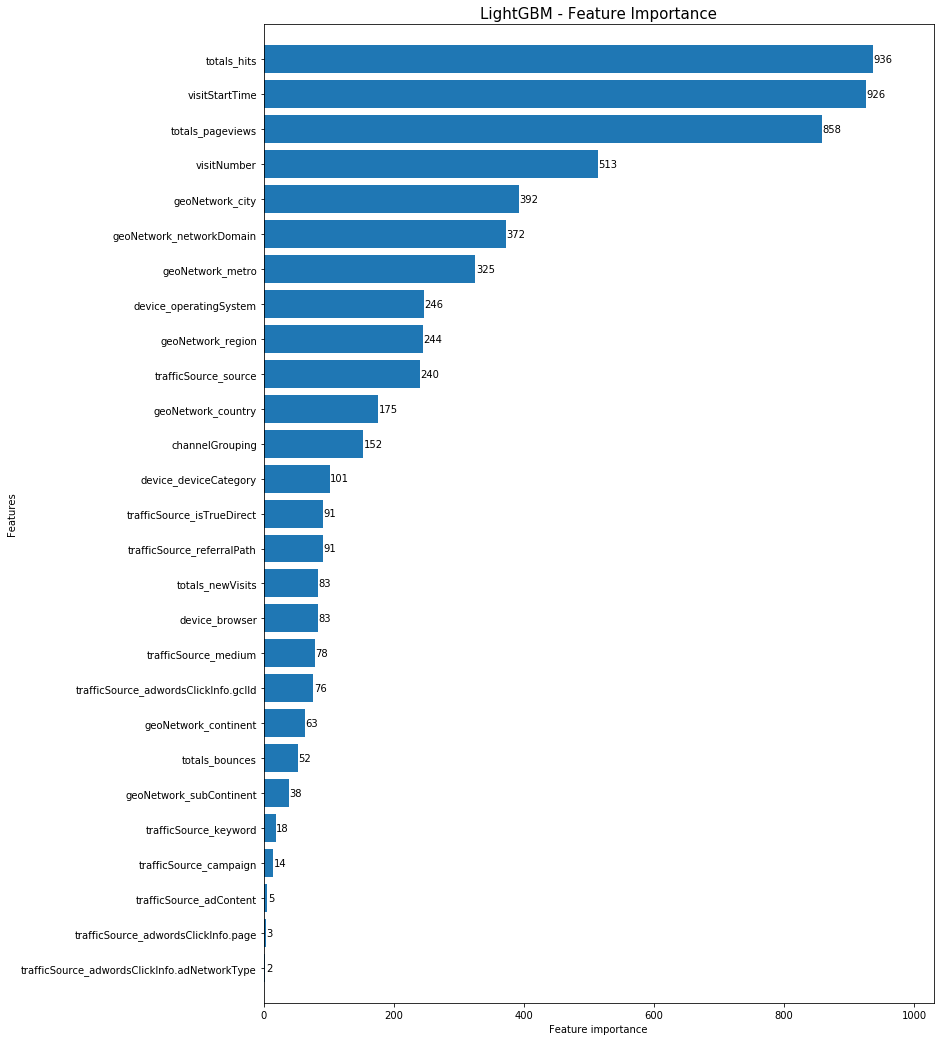

In [18]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [ ]:
test_visitor_id = test_df.fullVisitorId
test_df.drop(['date','fullVisitorId','visitId'], axis=1, inplace=True)
train_df.drop(['date','fullVisitorId','visitId'], axis=1, inplace=True)

In [ ]:
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')

In [86]:
values = train_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
train = values
train_X, train_y = train[:, :-1], train[:, -1]

In [87]:
# normalize features   #  Normalize complete data and than take test out
test_X = scaler.fit_transform(test_df)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1])) 
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


In [99]:
train_y = train_y.reshape((train_y.shape[0], 1))

In [100]:
train_y.shape

(903553, 1)

In [113]:
model = Sequential()
model.add(Dense(units=20,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=50))
model.add(Dense(units=30))
model.add(Dense(units=20))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(train_X, train_y, epochs=99, batch_size=33, verbose=2, shuffle=False) #validation_data=(test_X, test_y)
#model.save("lstm_model_headroom.h5")
yhat = model.predict(test_X)

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
y_predi = inv_yhat[0]

In [5]:
df_train.head(3)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


In [11]:
df1= df_train[['date','visitNumber','visitStartTime','device.browser','device.isMobile','device.deviceCategory','device.mobileDeviceMarketingName','device.operatingSystem',
              'geoNetwork.city','geoNetwork.continent','geoNetwork.country','geoNetwork.region','trafficSource.source','trafficSource.campaign',	
               'trafficSource.campaignCode','totals.transactionRevenue',
              'geoNetwork.subContinent','totals.bounces','totals.hits',	'totals.newVisits',	'totals.pageviews',		'totals.visits']]

In [12]:
df1.shape

(903653, 22)

In [22]:
pd.DataFrame(df1['totals.transactionRevenue']).isnull().sum()

totals.transactionRevenue    892138
dtype: int64

In [23]:
df1["totals.transactionRevenue"].fillna(0, inplace=True)

/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 22 columns):
date                                903653 non-null int64
visitNumber                         903653 non-null int64
visitStartTime                      903653 non-null int64
device.browser                      903653 non-null object
device.isMobile                     903653 non-null bool
device.deviceCategory               903653 non-null object
device.mobileDeviceMarketingName    903653 non-null object
device.operatingSystem              903653 non-null object
geoNetwork.city                     903653 non-null object
geoNetwork.continent                903653 non-null object
geoNetwork.country                  903653 non-null object
geoNetwork.region                   903653 non-null object
trafficSource.source                903653 non-null object
trafficSource.campaign              903653 non-null object
trafficSource.campaignCode          1 non-null object
totals.transac

In [27]:
df1.head(3)

,date,visitNumber,visitStartTime,device.browser,device.isMobile,device.deviceCategory,device.mobileDeviceMarketingName,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.region,trafficSource.source,trafficSource.campaign,trafficSource.campaignCode,totals.transactionRevenue,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits
0,20160902,1,1472830385,Chrome,False,desktop,not available in demo dataset,Windows,Izmir,Asia,Turkey,Izmir,google,(not set),NaN,0,Western Asia,1,1,1,1,1
1,20160902,1,1472880147,Firefox,False,desktop,not available in demo dataset,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,google,(not set),NaN,0,Australasia,1,1,1,1,1
2,20160902,1,1472865386,Chrome,False,desktop,not available in demo dataset,Windows,Madrid,Europe,Spain,Community of Madrid,google,(not set),NaN,0,Southern Europe,1,1,1,1,1


In [33]:
df1['totals.transactionRevenue'] = df1['totals.transactionRevenue'].astype('int')

/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
df1['totals.transactionRevenue'].unique() 

array([0, '37860000', '306670000', ..., '335260000', '30750000',
       '69390000'], dtype=object)

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

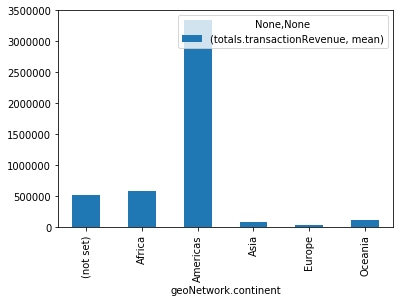

In [40]:
df1.groupby('geoNetwork.continent').agg({'totals.transactionRevenue':['mean']}).plot(kind='bar')


In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df1['device.browser'] = lb_make.fit_transform(df1['device.browser'])
df1['device.isMobile'] = lb_make.fit_transform(df1['device.isMobile'])
df1['device.deviceCategory'] = lb_make.fit_transform(df1['device.deviceCategory'])
df1['ddevice.mobileDeviceMarketingName'] = lb_make.fit_transform(df1['device.mobileDeviceMarketingName'])
df1['device.operatingSystem'] = lb_make.fit_transform(df1['device.operatingSystem'])
df1['geoNetwork.city'] = lb_make.fit_transform(df1['geoNetwork.city'])
df1['geoNetwork.continent'] = lb_make.fit_transform(df1['geoNetwork.continent'])
df1['device.browser'] = lb_make.fit_transform(df1['device.browser'])


In [ ]:
# Exploratory Analysis

In [ ]:
# Feature Selection

In [ ]:
# Model Fitting

In [ ]:
# Grid Search

In [ ]:
# Prediction

In [5]:
test.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6167871330617112363,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",6167871330617112363_1508151024,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""4""}","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508151024,2,1508151024
1,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0643697640977915618,"{""continent"": ""Europe"", ""subContinent"": ""South...",0643697640977915618_1508175522,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""5"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508175522,1,1508175522
2,Organic Search,20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6059383810968229466,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",6059383810968229466_1508143220,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""7"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508143220,1,1508143220
3,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2376720078563423631,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2376720078563423631_1508193530,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""8"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508193530,1,1508193530
4,Organic Search,20171016,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",2314544520795440038,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",2314544520795440038_1508217442,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""9"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508217442,1,1508217442


In [6]:
sample.head()

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.0
1,0000049363351866189,0.0
2,0000053049821714864,0.0
3,0000059488412965267,0.0
4,0000085840370633780,0.0


In [7]:
list(train.columns)==list(test.columns)

True

In [14]:
type(train.totals[10])

str

In [17]:
a = np.random.randint(1,20,50)
a

array([ 3, 18, 16,  9,  2, 16,  1, 17, 13,  9, 14,  5,  6,  9,  7, 16,  3,
        3, 18,  8, 10,  3, 13, 18, 12, 19,  4, 13,  8,  2, 10,  4, 17,  6,
        2, 12, 15, 10,  4,  4,  1, 11,  5, 15,  4,  7, 12,  1, 11, 19])

In [20]:
from collections import deque
b = deque(a)
b.rotate(1)     

In [22]:
c=a+b
c

array([22, 21, 34, 25, 11, 18, 17, 18, 30, 22, 23, 19, 11, 15, 16, 23, 19,
        6, 21, 26, 18, 13, 16, 31, 30, 31, 23, 17, 21, 10, 12, 14, 21, 23,
        8, 14, 27, 25, 14,  8,  5, 12, 16, 20, 19, 11, 19, 13, 12, 30])

In [24]:
c[0]=0
c

array([ 0, 21, 34, 25, 11, 18, 17, 18, 30, 22, 23, 19, 11, 15, 16, 23, 19,
        6, 21, 26, 18, 13, 16, 31, 30, 31, 23, 17, 21, 10, 12, 14, 21, 23,
        8, 14, 27, 25, 14,  8,  5, 12, 16, 20, 19, 11, 19, 13, 12, 30])

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/muratyalcin/Downloads/Murat Yalcin-c7166ca314fa.json"

In [ ]:
import bq_helper
#Here's how we can use the BQHelper library to pull datasets/tables from BigQuery
ga_bq_train = bq_helper.BigQueryHelper(active_project= "kaggle-public-datasets", 
                                       dataset_name = "ga_train_set")
ga_bq_test = bq_helper.BigQueryHelper(active_project= "kaggle-public-datasets", 
                                       dataset_name = "ga_test_set")
ga_bq_test.list_tables()

In [ ]:
query = """SELECT * FROM `kaggle-public-datasets.ga_train_set.ga_sessions_*`"""
train = ga_bq_train.query_to_pandas_safe(query)
train.shape

In [34]:
# Copyright 2015 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Define API Tables."""

from __future__ import absolute_import

import copy
import datetime
import operator
import warnings

import six
try:
    import pandas
except ImportError:  # pragma: NO COVER
    pandas = None

from google.api_core.page_iterator import HTTPIterator

import google.cloud._helpers
from google.cloud.bigquery import _helpers
from google.cloud.bigquery.schema import SchemaField
from google.cloud.bigquery.schema import _build_schema_resource
from google.cloud.bigquery.schema import _parse_schema_resource
from google.cloud.bigquery.external_config import ExternalConfig


_NO_PANDAS_ERROR = (
    'The pandas library is not installed, please install '
    'pandas to use the to_dataframe() function.'
)
_TABLE_HAS_NO_SCHEMA = 'Table has no schema:  call "client.get_table()"'
_MARKER = object()


def _reference_getter(table):
    """A :class:`~google.cloud.bigquery.table.TableReference` pointing to
    this table.

    Returns:
        google.cloud.bigquery.table.TableReference: pointer to this table.
    """
    from google.cloud.bigquery import dataset

    dataset_ref = dataset.DatasetReference(table.project, table.dataset_id)
    return TableReference(dataset_ref, table.table_id)


def _view_use_legacy_sql_getter(table):
    """bool: Specifies whether to execute the view with Legacy or Standard SQL.

    This boolean specifies whether to execute the view with Legacy SQL
    (:data:`True`) or Standard SQL (:data:`False`). The client side default is
    :data:`False`. The server-side default is :data:`True`. If this table is
    not a view, :data:`None` is returned.

    Raises:
        ValueError: For invalid value types.
    """
    view = table._properties.get('view')
    if view is not None:
        # The server-side default for useLegacySql is True.
        return view.get('useLegacySql', True)
    # In some cases, such as in a table list no view object is present, but the
    # resource still represents a view. Use the type as a fallback.
    if table.table_type == 'VIEW':
        # The server-side default for useLegacySql is True.
        return True


class EncryptionConfiguration(object):
    """Custom encryption configuration (e.g., Cloud KMS keys).

    Args:
        kms_key_name (str): resource ID of Cloud KMS key used for encryption
    """

    def __init__(self, kms_key_name=None):
        self._properties = {}
        if kms_key_name is not None:
            self._properties['kmsKeyName'] = kms_key_name


    @property
    def kms_key_name(self):
        """str: Resource ID of Cloud KMS key

        Resource ID of Cloud KMS key or :data:`None` if using default
        encryption.
        """
        return self._properties.get('kmsKeyName')

    @kms_key_name.setter
    def kms_key_name(self, value):
        self._properties['kmsKeyName'] = value

    @classmethod
    def from_api_repr(cls, resource):
        """Construct an encryption configuration from its API representation

        Args:
            resource (Dict[str, object]):
                An encryption configuration representation as returned from
                the API.

        Returns:
            google.cloud.bigquery.table.EncryptionConfiguration:
                An encryption configuration parsed from ``resource``.
        """
        config = cls()
        config._properties = copy.deepcopy(resource)
        return config


    def to_api_repr(self):
        """Construct the API resource representation of this encryption
        configuration.

        Returns:
            Dict[str, object]:
                Encryption configuration as represented as an API resource
        """
        return copy.deepcopy(self._properties)



class TableReference(object):
    """TableReferences are pointers to tables.

    See
    https://cloud.google.com/bigquery/docs/reference/rest/v2/tables

    Args:
        dataset_ref (google.cloud.bigquery.dataset.DatasetReference):
            A pointer to the dataset
        table_id (str): The ID of the table
    """

    def __init__(self, dataset_ref, table_id):
        self._project = dataset_ref.project
        self._dataset_id = dataset_ref.dataset_id
        self._table_id = table_id


    @property
    def project(self):
        """str: Project bound to the table"""
        return self._project

    @property
    def dataset_id(self):
        """str: ID of dataset containing the table."""
        return self._dataset_id

    @property
    def table_id(self):
        """str: The table ID."""
        return self._table_id

    @property
    def path(self):
        """str: URL path for the table's APIs."""
        return '/projects/%s/datasets/%s/tables/%s' % (
            self._project, self._dataset_id, self._table_id)

    @classmethod
    def from_string(cls, table_id, default_project=None):
        """Construct a table reference from table ID string.

        Args:
            table_id (str):
                A table ID in standard SQL format. If ``default_project``
                is not specified, this must included a project ID, dataset
                ID, and table ID, each separated by ``.``.
            default_project (str):
                Optional. The project ID to use when ``table_id`` does not
                include a project ID.

        Returns:
            TableReference: Table reference parsed from ``table_id``.

        Examples:
            >>> TableReference.from_string('my-project.mydataset.mytable')
            TableRef...(DatasetRef...('my-project', 'mydataset'), 'mytable')

        Raises:
            ValueError:
                If ``table_id`` is not a fully-qualified table ID in
                standard SQL format.
        """
        from google.cloud.bigquery.dataset import DatasetReference

        output_project_id = default_project
        output_dataset_id = None
        output_table_id = None
        parts = table_id.split('.')

        if len(parts) < 2:
            raise ValueError(
                'table_id must be a fully-qualified table ID in '
                'standard SQL format. e.g. "project.dataset.table", got '
                '{}'.format(table_id))
        elif len(parts) == 2:
            if not default_project:
                raise ValueError(
                    'When default_project is not set, table_id must be a '
                    'fully-qualified table ID in standard SQL format. '
                    'e.g. "project.dataset_id.table_id", got {}'.format(
                        table_id))
            output_dataset_id, output_table_id = parts
        elif len(parts) == 3:
            output_project_id, output_dataset_id, output_table_id = parts
        if len(parts) > 3:
            raise ValueError(
                'Too many parts in table_id. Must be a fully-qualified table '
                'ID in standard SQL format. e.g. "project.dataset.table", '
                'got {}'.format(table_id))

        return cls(
            DatasetReference(output_project_id, output_dataset_id),
            output_table_id,
        )


    @classmethod
    def from_api_repr(cls, resource):
        """Factory:  construct a table reference given its API representation

        Args:
            resource (Dict[str, object]):
                Table reference representation returned from the API

        Returns:
            google.cloud.bigquery.table.TableReference:
                Table reference parsed from ``resource``.
        """
        from google.cloud.bigquery.dataset import DatasetReference

        project = resource['projectId']
        dataset_id = resource['datasetId']
        table_id = resource['tableId']
        return cls(DatasetReference(project, dataset_id), table_id)


    def to_api_repr(self):
        """Construct the API resource representation of this table reference.

        Returns:
            Dict[str, object]: Table reference represented as an API resource
        """
        return {
            'projectId': self._project,
            'datasetId': self._dataset_id,
            'tableId': self._table_id,
        }


    def _key(self):
        """A tuple key that uniquely describes this field.

        Used to compute this instance's hashcode and evaluate equality.

        Returns:
            Tuple[str]: The contents of this :class:`DatasetReference`.
        """
        return (
            self._project,
            self._dataset_id,
            self._table_id,
        )

    def __eq__(self, other):
        if not isinstance(other, TableReference):
            return NotImplemented
        return self._key() == other._key()

    def __ne__(self, other):
        return not self == other

    def __hash__(self):
        return hash(self._key())

    def __repr__(self):
        from google.cloud.bigquery.dataset import DatasetReference
        dataset_ref = DatasetReference(self._project, self._dataset_id)
        return "TableReference({}, '{}')".format(
            repr(dataset_ref), self._table_id)



class Table(object):
    """Tables represent a set of rows whose values correspond to a schema.

    See
    https://cloud.google.com/bigquery/docs/reference/rest/v2/tables

    Args:
        table_ref (google.cloud.bigquery.table.TableReference):
            A pointer to a table
        schema (List[google.cloud.bigquery.schema.SchemaField]):
            The table's schema
    """

    _PROPERTY_TO_API_FIELD = {
        'friendly_name': 'friendlyName',
        'expires': 'expirationTime',
        'time_partitioning': 'timePartitioning',
        'partitioning_type': 'timePartitioning',
        'partition_expiration': 'timePartitioning',
        'view_use_legacy_sql': 'view',
        'view_query': 'view',
        'external_data_configuration': 'externalDataConfiguration',
        'encryption_configuration': 'encryptionConfiguration',
    }

    def __init__(self, table_ref, schema=None):
        self._properties = {
            'tableReference': table_ref.to_api_repr(),
            'labels': {},
        }
        # Let the @property do validation.
        if schema is not None:
            self.schema = schema


    @property
    def project(self):
        """str: Project bound to the table."""
        return self._properties['tableReference']['projectId']

    @property
    def dataset_id(self):
        """str: ID of dataset containing the table."""
        return self._properties['tableReference']['datasetId']

    @property
    def table_id(self):
        """str: ID of the table."""
        return self._properties['tableReference']['tableId']

    reference = property(_reference_getter)

    @property
    def path(self):
        """str: URL path for the table's APIs."""
        return '/projects/%s/datasets/%s/tables/%s' % (
            self.project, self.dataset_id, self.table_id)

    @property
    def schema(self):
        """List[google.cloud.bigquery.schema.SchemaField]: Table's schema.

        Raises:
            TypeError: If 'value' is not a sequence
            ValueError:
                If any item in the sequence is not a
                :class:`~google.cloud.bigquery.schema.SchemaField`
        """
        prop = self._properties.get('schema')
        if not prop:
            return []
        else:
            return _parse_schema_resource(prop)

    @schema.setter
    def schema(self, value):
        if value is None:
            self._properties['schema'] = None
        elif not all(isinstance(field, SchemaField) for field in value):
            raise ValueError('Schema items must be fields')
        else:
            self._properties['schema'] = {
                'fields': _build_schema_resource(value)
            }

    @property
    def labels(self):
        """Dict[str, str]: Labels for the table.

        This method always returns a dict. To change a table's labels,
        modify the dict, then call ``Client.update_table``. To delete a
        label, set its value to :data:`None` before updating.

        Raises:
            ValueError: If ``value`` type is invalid.
        """
        return self._properties.setdefault('labels', {})

    @labels.setter
    def labels(self, value):
        if not isinstance(value, dict):
            raise ValueError("Pass a dict")
        self._properties['labels'] = value

    @property
    def encryption_configuration(self):
        """google.cloud.bigquery.table.EncryptionConfiguration: Custom
        encryption configuration for the table.

        Custom encryption configuration (e.g., Cloud KMS keys) or :data:`None`
        if using default encryption.

        See `protecting data with Cloud KMS keys
        <https://cloud.google.com/bigquery/docs/customer-managed-encryption>`_
        in the BigQuery documentation.
        """
        prop = self._properties.get('encryptionConfiguration')
        if prop is not None:
            prop = EncryptionConfiguration.from_api_repr(prop)
        return prop

    @encryption_configuration.setter
    def encryption_configuration(self, value):
        api_repr = value
        if value is not None:
            api_repr = value.to_api_repr()
        self._properties['encryptionConfiguration'] = api_repr

    @property
    def created(self):
        """Union[datetime.datetime, None]: Datetime at which the table was
        created (:data:`None` until set from the server).
        """
        creation_time = self._properties.get('creationTime')
        if creation_time is not None:
            # creation_time will be in milliseconds.
            return google.cloud._helpers._datetime_from_microseconds(
                1000.0 * float(creation_time))

    @property
    def etag(self):
        """Union[str, None]: ETag for the table resource (:data:`None` until
        set from the server).
        """
        return self._properties.get('etag')

    @property
    def modified(self):
        """Union[datetime.datetime, None]: Datetime at which the table was last
        modified (:data:`None` until set from the server).
        """
        modified_time = self._properties.get('lastModifiedTime')
        if modified_time is not None:
            # modified_time will be in milliseconds.
            return google.cloud._helpers._datetime_from_microseconds(
                1000.0 * float(modified_time))

    @property
    def num_bytes(self):
        """Union[int, None]: The size of the table in bytes (:data:`None` until
        set from the server).
        """
        return _helpers._int_or_none(self._properties.get('numBytes'))

    @property
    def num_rows(self):
        """Union[int, None]: The number of rows in the table (:data:`None`
        until set from the server).
        """
        return _helpers._int_or_none(self._properties.get('numRows'))

    @property
    def self_link(self):
        """Union[str, None]: URL for the table resource (:data:`None` until set
        from the server).
        """
        return self._properties.get('selfLink')

    @property
    def full_table_id(self):
        """Union[str, None]: ID for the table (:data:`None` until set from the
        server).

        In the format ``project_id:dataset_id.table_id``.
        """
        return self._properties.get('id')

    @property
    def table_type(self):
        """Union[str, None]: The type of the table (:data:`None` until set from
        the server).

        Possible values are ``'TABLE'``, ``'VIEW'``, or ``'EXTERNAL'``.
        """
        return self._properties.get('type')

    @property
    def time_partitioning(self):
        """google.cloud.bigquery.table.TimePartitioning: Configures time-based
        partitioning for a table.

        Raises:
            ValueError:
                If the value is not :class:`TimePartitioning` or :data:`None`.
        """
        prop = self._properties.get('timePartitioning')
        if prop is not None:
            return TimePartitioning.from_api_repr(prop)

    @time_partitioning.setter
    def time_partitioning(self, value):
        api_repr = value
        if isinstance(value, TimePartitioning):
            api_repr = value.to_api_repr()
        elif value is not None:
            raise ValueError(
                "value must be google.cloud.bigquery.table.TimePartitioning "
                "or None")
        self._properties['timePartitioning'] = api_repr

    @property
    def partitioning_type(self):
        """Union[str, None]: Time partitioning of the table if it is
        partitioned (Defaults to :data:`None`).

        The only partitioning type that is currently supported is
        :attr:`~google.cloud.bigquery.table.TimePartitioningType.DAY`.
        """
        warnings.warn(
            "This method will be deprecated in future versions. Please use "
            "Table.time_partitioning.type_ instead.",
            UserWarning)
        if self.time_partitioning is not None:
            return self.time_partitioning.type_

    @partitioning_type.setter
    def partitioning_type(self, value):
        warnings.warn(
            "This method will be deprecated in future versions. Please use "
            "Table.time_partitioning.type_ instead.",
            UserWarning)
        if self.time_partitioning is None:
            self._properties['timePartitioning'] = {}
        self._properties['timePartitioning']['type'] = value

    @property
    def partition_expiration(self):
        """Union[int, None]: Expiration time in milliseconds for a partition.

        If :attr:`partition_expiration` is set and :attr:`type_` is
        not set, :attr:`type_` will default to
        :attr:`~google.cloud.bigquery.table.TimePartitioningType.DAY`.
        """
        warnings.warn(
            "This method will be deprecated in future versions. Please use "
            "Table.time_partitioning.expiration_ms instead.",
            UserWarning)
        if self.time_partitioning is not None:
            return self.time_partitioning.expiration_ms

    @partition_expiration.setter
    def partition_expiration(self, value):
        warnings.warn(
            "This method will be deprecated in future versions. Please use "
            "Table.time_partitioning.expiration_ms instead.",
            UserWarning)
        if self.time_partitioning is None:
            self._properties['timePartitioning'] = {
                'type': TimePartitioningType.DAY}
        self._properties['timePartitioning']['expirationMs'] = str(value)

    @property
    def clustering_fields(self):
        """Union[List[str], None]: Fields defining clustering for the table

        (Defaults to :data:`None`).

        Clustering fields are immutable after table creation.

        .. note::

           As of 2018-06-29, clustering fields cannot be set on a table
           which does not also have time partioning defined.
        """
        prop = self._properties.get('clustering')
        if prop is not None:
            return list(prop.get('fields', ()))

    @clustering_fields.setter
    def clustering_fields(self, value):
        """Union[List[str], None]: Fields defining clustering for the table

        (Defaults to :data:`None`).
        """
        if value is not None:
            prop = self._properties.setdefault('clustering', {})
            prop['fields'] = value
        else:
            if 'clustering' in self._properties:
                del self._properties['clustering']

    @property
    def description(self):
        """Union[str, None]: Description of the table (defaults to
        :data:`None`).

        Raises:
            ValueError: For invalid value types.
        """
        return self._properties.get('description')

    @description.setter
    def description(self, value):
        if not isinstance(value, six.string_types) and value is not None:
            raise ValueError("Pass a string, or None")
        self._properties['description'] = value

    @property
    def expires(self):
        """Union[datetime.datetime, None]: Datetime at which the table will be
        deleted.

        Raises:
            ValueError: For invalid value types.
        """
        expiration_time = self._properties.get('expirationTime')
        if expiration_time is not None:
            # expiration_time will be in milliseconds.
            return google.cloud._helpers._datetime_from_microseconds(
                1000.0 * float(expiration_time))

    @expires.setter
    def expires(self, value):
        if not isinstance(value, datetime.datetime) and value is not None:
            raise ValueError("Pass a datetime, or None")
        value_ms = google.cloud._helpers._millis_from_datetime(value)
        self._properties['expirationTime'] = _helpers._str_or_none(value_ms)

    @property
    def friendly_name(self):
        """Union[str, None]: Title of the table (defaults to :data:`None`).

        Raises:
            ValueError: For invalid value types.
        """
        return self._properties.get('friendlyName')

    @friendly_name.setter
    def friendly_name(self, value):
        if not isinstance(value, six.string_types) and value is not None:
            raise ValueError("Pass a string, or None")
        self._properties['friendlyName'] = value

    @property
    def location(self):
        """Union[str, None]: Location in which the table is hosted

        Defaults to :data:`None`.
        """
        return self._properties.get('location')

    @property
    def view_query(self):
        """Union[str, None]: SQL query defining the table as a view (defaults
        to :data:`None`).

        By default, the query is treated as Standard SQL. To use Legacy
        SQL, set :attr:`view_use_legacy_sql` to :data:`True`.

        Raises:
            ValueError: For invalid value types.
        """
        view = self._properties.get('view')
        if view is not None:
            return view.get('query')

    @view_query.setter
    def view_query(self, value):
        if not isinstance(value, six.string_types):
            raise ValueError("Pass a string")
        view = self._properties.get('view')
        if view is None:
            view = self._properties['view'] = {}
        view['query'] = value
        # The service defaults useLegacySql to True, but this
        # client uses Standard SQL by default.
        if view.get('useLegacySql') is None:
            view['useLegacySql'] = False

    @view_query.deleter
    def view_query(self):
        """Delete SQL query defining the table as a view."""
        self._properties.pop('view', None)

    view_use_legacy_sql = property(_view_use_legacy_sql_getter)

    @view_use_legacy_sql.setter
    def view_use_legacy_sql(self, value):
        if not isinstance(value, bool):
            raise ValueError("Pass a boolean")
        if self._properties.get('view') is None:
            self._properties['view'] = {}
        self._properties['view']['useLegacySql'] = value

    @property
    def streaming_buffer(self):
        """google.cloud.bigquery.StreamingBuffer: Information about a table's
        streaming buffer.
        """
        sb = self._properties.get('streamingBuffer')
        if sb is not None:
            return StreamingBuffer(sb)

    @property
    def external_data_configuration(self):
        """Union[google.cloud.bigquery.ExternalConfig, None]: Configuration for
        an external data source (defaults to :data:`None`).

        Raises:
            ValueError: For invalid value types.
        """
        prop = self._properties.get('externalDataConfiguration')
        if prop is not None:
            prop = ExternalConfig.from_api_repr(prop)
        return prop

    @external_data_configuration.setter
    def external_data_configuration(self, value):
        if not (value is None or isinstance(value, ExternalConfig)):
            raise ValueError("Pass an ExternalConfig or None")
        api_repr = value
        if value is not None:
            api_repr = value.to_api_repr()
        self._properties['externalDataConfiguration'] = api_repr

    @classmethod
    def from_string(cls, full_table_id):
        """Construct a table from fully-qualified table ID.

        Args:
            full_table_id (str):
                A fully-qualified table ID in standard SQL format. Must
                included a project ID, dataset ID, and table ID, each
                separated by ``.``.

        Returns:
            Table: Table parsed from ``full_table_id``.

        Examples:
            >>> Table.from_string('my-project.mydataset.mytable')
            Table(TableRef...(D...('my-project', 'mydataset'), 'mytable'))

        Raises:
            ValueError:
                If ``full_table_id`` is not a fully-qualified table ID in
                standard SQL format.
        """
        return cls(TableReference.from_string(full_table_id))


    @classmethod
    def from_api_repr(cls, resource):
        """Factory: construct a table given its API representation

        Args:
            resource (Dict[str, object]):
                Table resource representation from the API
            dataset (google.cloud.bigquery.dataset.Dataset):
                The dataset containing the table.

        Returns:
            google.cloud.bigquery.table.Table: Table parsed from ``resource``.

        Raises:
            KeyError:
                If the ``resource`` lacks the key ``'tableReference'``, or if
                the ``dict`` stored within the key ``'tableReference'`` lacks
                the keys ``'tableId'``, ``'projectId'``, or ``'datasetId'``.
        """
        from google.cloud.bigquery import dataset

        if ('tableReference' not in resource or
                'tableId' not in resource['tableReference']):
            raise KeyError('Resource lacks required identity information:'
                           '["tableReference"]["tableId"]')
        project_id = resource['tableReference']['projectId']
        table_id = resource['tableReference']['tableId']
        dataset_id = resource['tableReference']['datasetId']
        dataset_ref = dataset.DatasetReference(project_id, dataset_id)

        table = cls(dataset_ref.table(table_id))
        table._properties = resource

        return table


    def to_api_repr(self):
        """Constructs the API resource of this table

        Returns:
            Dict[str, object]: Table represented as an API resource
        """
        return copy.deepcopy(self._properties)


    def _build_resource(self, filter_fields):
        """Generate a resource for ``update``."""
        partial = {}
        for filter_field in filter_fields:
            api_field = self._PROPERTY_TO_API_FIELD.get(filter_field)
            if api_field is None and filter_field not in self._properties:
                raise ValueError('No Table property %s' % filter_field)
            elif api_field is not None:
                partial[api_field] = self._properties.get(api_field)
            else:
                # allows properties that are not defined in the library
                # and properties that have the same name as API resource key
                partial[filter_field] = self._properties[filter_field]

        return partial

    def __repr__(self):
        return 'Table({})'.format(repr(self.reference))


class TableListItem(object):
    """A read-only table resource from a list operation.

    For performance reasons, the BigQuery API only includes some of the table
    properties when listing tables. Notably,
    :attr:`~google.cloud.bigquery.table.Table.schema` and
    :attr:`~google.cloud.bigquery.table.Table.num_rows` are missing.

    For a full list of the properties that the BigQuery API returns, see the
    `REST documentation for tables.list
    <https://cloud.google.com/bigquery/docs/reference/rest/v2/tables/list>`_.


    Args:
        resource (Dict[str, object]):
            A table-like resource object from a table list response. A
            ``tableReference`` property is required.

    Raises:
        ValueError:
            If ``tableReference`` or one of its required members is missing
            from ``resource``.
    """

    def __init__(self, resource):
        if 'tableReference' not in resource:
            raise ValueError('resource must contain a tableReference value')
        if 'projectId' not in resource['tableReference']:
            raise ValueError(
                "resource['tableReference'] must contain a projectId value")
        if 'datasetId' not in resource['tableReference']:
            raise ValueError(
                "resource['tableReference'] must contain a datasetId value")
        if 'tableId' not in resource['tableReference']:
            raise ValueError(
                "resource['tableReference'] must contain a tableId value")

        self._properties = resource


    @property
    def project(self):
        """str: Project bound to the table."""
        return self._properties['tableReference']['projectId']

    @property
    def dataset_id(self):
        """str: ID of dataset containing the table."""
        return self._properties['tableReference']['datasetId']

    @property
    def table_id(self):
        """str: ID of the table."""
        return self._properties['tableReference']['tableId']

    reference = property(_reference_getter)

    @property
    def labels(self):
        """Dict[str, str]: Labels for the table.

        This method always returns a dict. To change a table's labels,
        modify the dict, then call ``Client.update_table``. To delete a
        label, set its value to :data:`None` before updating.
        """
        return self._properties.setdefault('labels', {})

    @property
    def full_table_id(self):
        """Union[str, None]: ID for the table (:data:`None` until set from the
        server).

        In the format ``project_id:dataset_id.table_id``.
        """
        return self._properties.get('id')

    @property
    def table_type(self):
        """Union[str, None]: The type of the table (:data:`None` until set from
        the server).

        Possible values are ``'TABLE'``, ``'VIEW'``, or ``'EXTERNAL'``.
        """
        return self._properties.get('type')

    @property
    def time_partitioning(self):
        """google.cloud.bigquery.table.TimePartitioning: Configures time-based
        partitioning for a table.
        """
        prop = self._properties.get('timePartitioning')
        if prop is not None:
            return TimePartitioning.from_api_repr(prop)

    @property
    def partitioning_type(self):
        """Union[str, None]: Time partitioning of the table if it is
        partitioned (Defaults to :data:`None`).
        """
        warnings.warn(
            "This method will be deprecated in future versions. Please use "
            "TableListItem.time_partitioning.type_ instead.",
            PendingDeprecationWarning)
        if self.time_partitioning is not None:
            return self.time_partitioning.type_

    @property
    def partition_expiration(self):
        """Union[int, None]: Expiration time in milliseconds for a partition.

        If this property is set and :attr:`type_` is not set, :attr:`type_`
        will default to :attr:`TimePartitioningType.DAY`.
        """
        warnings.warn(
            "This method will be deprecated in future versions. Please use "
            "TableListItem.time_partitioning.expiration_ms instead.",
            PendingDeprecationWarning)
        if self.time_partitioning is not None:
            return self.time_partitioning.expiration_ms

    @property
    def friendly_name(self):
        """Union[str, None]: Title of the table (defaults to :data:`None`)."""
        return self._properties.get('friendlyName')

    view_use_legacy_sql = property(_view_use_legacy_sql_getter)



def _row_from_mapping(mapping, schema):
    """Convert a mapping to a row tuple using the schema.

    Args:
        mapping (Dict[str, object])
            Mapping of row data: must contain keys for all required fields in
            the schema. Keys which do not correspond to a field in the schema
            are ignored.
        schema (List[google.cloud.bigquery.schema.SchemaField]):
            The schema of the table destination for the rows

    Returns:
        Tuple[object]:
            Tuple whose elements are ordered according to the schema.

    Raises:
        ValueError: If schema is empty.
    """
    if len(schema) == 0:
        raise ValueError(_TABLE_HAS_NO_SCHEMA)

    row = []
    for field in schema:
        if field.mode == 'REQUIRED':
            row.append(mapping[field.name])
        elif field.mode == 'REPEATED':
            row.append(mapping.get(field.name, ()))
        elif field.mode == 'NULLABLE':
            row.append(mapping.get(field.name))
        else:
            raise ValueError(
                "Unknown field mode: {}".format(field.mode))
    return tuple(row)


class StreamingBuffer(object):
    """Information about a table's streaming buffer.

    See https://cloud.google.com/bigquery/streaming-data-into-bigquery.

    Args:
        resource (Dict[str, object]):
            streaming buffer representation returned from the API
    """

    def __init__(self, resource):
        self.estimated_bytes = int(resource['estimatedBytes'])
        self.estimated_rows = int(resource['estimatedRows'])
        # time is in milliseconds since the epoch.
        self.oldest_entry_time = (
            google.cloud._helpers._datetime_from_microseconds(
                1000.0 * int(resource['oldestEntryTime'])))


class Row(object):
    """A BigQuery row.

    Values can be accessed by position (index), by key like a dict,
    or as properties.

    Args:
        values (Sequence[object]): The row values
        field_to_index (Dict[str, int]):
            A mapping from schema field names to indexes
    """

    # Choose unusual field names to try to avoid conflict with schema fields.
    __slots__ = ('_xxx_values', '_xxx_field_to_index')

    def __init__(self, values, field_to_index):
        self._xxx_values = values
        self._xxx_field_to_index = field_to_index


    def values(self):
        """Return the values included in this row.

        Returns:
            Sequence[object]: A sequence of length ``len(row)``.
        """
        return copy.deepcopy(self._xxx_values)


    def keys(self):
        """Return the keys for using a row as a dict.

        Returns:
            Iterable[str]: The keys corresponding to the columns of a row

        Examples:

            >>> list(Row(('a', 'b'), {'x': 0, 'y': 1}).keys())
            ['x', 'y']
        """
        return six.iterkeys(self._xxx_field_to_index)


    def items(self):
        """Return items as ``(key, value)`` pairs.

        Returns:
            Iterable[Tuple[str, object]]:
                The ``(key, value)`` pairs representing this row.

        Examples:

            >>> list(Row(('a', 'b'), {'x': 0, 'y': 1}).items())
            [('x', 'a'), ('y', 'b')]
        """
        for key, index in six.iteritems(self._xxx_field_to_index):
            yield (key, copy.deepcopy(self._xxx_values[index]))


    def get(self, key, default=None):
        """Return a value for key, with a default value if it does not exist.

        Args:
            key (str): The key of the column to access
            default (object):
                The default value to use if the key does not exist. (Defaults
                to :data:`None`.)

        Returns:
            object:
                The value associated with the provided key, or a default value.

        Examples:
            When the key exists, the value associated with it is returned.

            >>> Row(('a', 'b'), {'x': 0, 'y': 1}).get('x')
            'a'

            The default value is :data:`None` when the key does not exist.

            >>> Row(('a', 'b'), {'x': 0, 'y': 1}).get('z')
            None

            The default value can be overrided with the ``default`` parameter.

            >>> Row(('a', 'b'), {'x': 0, 'y': 1}).get('z', '')
            ''

            >>> Row(('a', 'b'), {'x': 0, 'y': 1}).get('z', default = '')
            ''
        """
        index = self._xxx_field_to_index.get(key)
        if index is None:
            return default
        return self._xxx_values[index]


    def __getattr__(self, name):
        value = self._xxx_field_to_index.get(name)
        if value is None:
            raise AttributeError('no row field {!r}'.format(name))
        return self._xxx_values[value]

    def __len__(self):
        return len(self._xxx_values)

    def __getitem__(self, key):
        if isinstance(key, six.string_types):
            value = self._xxx_field_to_index.get(key)
            if value is None:
                raise KeyError('no row field {!r}'.format(key))
            key = value
        return self._xxx_values[key]

    def __eq__(self, other):
        if not isinstance(other, Row):
            return NotImplemented
        return(
            self._xxx_values == other._xxx_values and
            self._xxx_field_to_index == other._xxx_field_to_index)

    def __ne__(self, other):
        return not self == other

    def __repr__(self):
        # sort field dict by value, for determinism
        items = sorted(self._xxx_field_to_index.items(),
                       key=operator.itemgetter(1))
        f2i = '{' + ', '.join('%r: %d' % item for item in items) + '}'
        return 'Row({}, {})'.format(self._xxx_values, f2i)



class RowIterator(HTTPIterator):
    """A class for iterating through HTTP/JSON API row list responses.

    Args:
        client (google.cloud.bigquery.Client): The API client.
        api_request (Callable[google.cloud._http.JSONConnection.api_request]):
            The function to use to make API requests.
        path (str): The method path to query for the list of items.
        page_token (str): A token identifying a page in a result set to start
            fetching results from.
        max_results (int, optional): The maximum number of results to fetch.
        page_size (int, optional): The number of items to return per page.
        extra_params (Dict[str, object]):
            Extra query string parameters for the API call.
    """

    def __init__(self, client, api_request, path, schema, page_token=None,
                 max_results=None, page_size=None, extra_params=None):
        super(RowIterator, self).__init__(
            client, api_request, path, item_to_value=_item_to_row,
            items_key='rows', page_token=page_token, max_results=max_results,
            extra_params=extra_params, page_start=_rows_page_start,
            next_token='pageToken')
        self._schema = schema
        self._field_to_index = _helpers._field_to_index_mapping(schema)
        self._total_rows = None
        self._page_size = page_size


    def _get_next_page_response(self):
        """Requests the next page from the path provided.

        Returns:
            Dict[str, object]:
                The parsed JSON response of the next page's contents.
        """
        params = self._get_query_params()
        if self._page_size is not None:
            params['maxResults'] = self._page_size
        return self.api_request(
            method=self._HTTP_METHOD,
            path=self.path,
            query_params=params)

    @property
    def schema(self):
        """List[google.cloud.bigquery.schema.SchemaField]: Table's schema."""
        return list(self._schema)

    @property
    def total_rows(self):
        """int: The total number of rows in the table."""
        return self._total_rows

    def to_dataframe(self):
        """Create a pandas DataFrame from the query results.

        Returns:
            pandas.DataFrame:
                A :class:`~pandas.DataFrame` populated with row data and column
                headers from the query results. The column headers are derived
                from the destination table's schema.

        Raises:
            ValueError: If the :mod:`pandas` library cannot be imported.

        """
        if pandas is None:
            raise ValueError(_NO_PANDAS_ERROR)

        column_headers = [field.name for field in self.schema]
        # Use generator, rather than pulling the whole rowset into memory.
        rows = (row.values() for row in iter(self))

        return pandas.DataFrame(rows, columns=column_headers)



class _EmptyRowIterator(object):
    """An empty row iterator.

    This class prevents API requests when there are no rows to fetch or rows
    are impossible to fetch, such as with query results for DDL CREATE VIEW
    statements.
    """
    schema = ()
    pages = ()
    total_rows = 0

    def to_dataframe(self):
        if pandas is None:
            raise ValueError(_NO_PANDAS_ERROR)
        return pandas.DataFrame()

    def __iter__(self):
        return iter(())


class TimePartitioningType(object):
    """Specifies the type of time partitioning to perform."""

    DAY = 'DAY'
    """str: Generates one partition per day."""



class TimePartitioning(object):
    """Configures time-based partitioning for a table.

    Args:
        type_ (google.cloud.bigquery.table.TimePartitioningType, optional):
            Specifies the type of time partitioning to perform. Defaults to
            :attr:`~google.cloud.bigquery.table.TimePartitioningType.DAY`,
            which is the only currently supported type.
        field (str, optional):
            If set, the table is partitioned by this field. If not set, the
            table is partitioned by pseudo column ``_PARTITIONTIME``. The field
            must be a top-level ``TIMESTAMP`` or ``DATE`` field. Its mode must
            be ``NULLABLE`` or ``REQUIRED``.
        expiration_ms(int, optional):
            Number of milliseconds for which to keep the storage for a
            partition.
        require_partition_filter (bool, optional):
            If set to true, queries over the partitioned table require a
            partition filter that can be used for partition elimination to be
            specified.
    """
    def __init__(self, type_=None, field=None, expiration_ms=None,
                 require_partition_filter=None):
        self._properties = {}
        if type_ is None:
            self.type_ = TimePartitioningType.DAY
        else:
            self.type_ = type_
        if field is not None:
            self.field = field
        if expiration_ms is not None:
            self.expiration_ms = expiration_ms
        if require_partition_filter is not None:
            self.require_partition_filter = require_partition_filter


    @property
    def type_(self):
        """google.cloud.bigquery.table.TimePartitioningType: The type of time
        partitioning to use.
        """
        return self._properties['type']

    @type_.setter
    def type_(self, value):
        self._properties['type'] = value

    @property
    def field(self):
        """str: Field in the table to use for partitioning"""
        return self._properties.get('field')

    @field.setter
    def field(self, value):
        self._properties['field'] = value

    @property
    def expiration_ms(self):
        """int: Number of milliseconds to keep the storage for a partition."""
        return _helpers._int_or_none(self._properties.get('expirationMs'))

    @expiration_ms.setter
    def expiration_ms(self, value):
        self._properties['expirationMs'] = str(value)

    @property
    def require_partition_filter(self):
        """bool: Specifies whether partition filters are required for queries
        """
        return self._properties.get('requirePartitionFilter')

    @require_partition_filter.setter
    def require_partition_filter(self, value):
        self._properties['requirePartitionFilter'] = value

    @classmethod
    def from_api_repr(cls, api_repr):
        """Return a :class:`TimePartitioning` object deserialized from a dict.

        This method creates a new ``TimePartitioning`` instance that points to
        the ``api_repr`` parameter as its internal properties dict. This means
        that when a ``TimePartitioning`` instance is stored as a property of
        another object, any changes made at the higher level will also appear
        here::

            >>> time_partitioning = TimePartitioning()
            >>> table.time_partitioning = time_partitioning
            >>> table.time_partitioning.field = 'timecolumn'
            >>> time_partitioning.field
            'timecolumn'

        Args:
            api_repr (Mapping[str, str]):
                The serialized representation of the TimePartitioning, such as
                what is output by :meth:`to_api_repr`.

        Returns:
            google.cloud.bigquery.table.TimePartitioning:
                The ``TimePartitioning`` object.
        """
        instance = cls(api_repr['type'])
        instance._properties = api_repr
        return instance


    def to_api_repr(self):
        """Return a dictionary representing this object.

        This method returns the properties dict of the ``TimePartitioning``
        instance rather than making a copy. This means that when a
        ``TimePartitioning`` instance is stored as a property of another
        object, any changes made at the higher level will also appear here.

        Returns:
            dict:
                A dictionary representing the TimePartitioning object in
                serialized form.
        """
        return self._properties



def _item_to_row(iterator, resource):
    """Convert a JSON row to the native object.

    .. note::

        This assumes that the ``schema`` attribute has been
        added to the iterator after being created, which
        should be done by the caller.

    :type iterator: :class:`~google.api_core.page_iterator.Iterator`
    :param iterator: The iterator that is currently in use.

    :type resource: dict
    :param resource: An item to be converted to a row.

    :rtype: :class:`~google.cloud.bigquery.table.Row`
    :returns: The next row in the page.
    """
    return Row(_helpers._row_tuple_from_json(resource, iterator.schema),
               iterator._field_to_index)


# pylint: disable=unused-argument
def _rows_page_start(iterator, page, response):
    """Grab total rows when :class:`~google.cloud.iterator.Page` starts.

    :type iterator: :class:`~google.api_core.page_iterator.Iterator`
    :param iterator: The iterator that is currently in use.

    :type page: :class:`~google.api_core.page_iterator.Page`
    :param page: The page that was just created.

    :type response: dict
    :param response: The JSON API response for a page of rows in a table.
    """
    total_rows = response.get('totalRows')
    if total_rows is not None:
        total_rows = int(total_rows)
    iterator._total_rows = total_rows
# pylint: enable=unused-argument

